### Import libraries

In [1]:
from os.path import sep, exists
from ScanImageTiffReader import ScanImageTiffReader
from skimage.registration import phase_cross_correlation
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import fourier_shift
import numpy as np
from matplotlib import pyplot as plt
import napari
import cv2 as cv
import pandas as pd
import re

### Point to the data

In [2]:
dataDir = 'C:\\Users\\dantu\\Documents\\Data\\G-E\\TwoWorlds\\20201210\\'
rawTiff = 'Fly1_6-7days_7fx60D05_00001.tif'
plotDir = sep.join(dataDir.split(sep)[:-2])+sep+'plots'

print(dataDir)
print(plotDir)

C:\Users\dantu\Documents\Data\G-E\TwoWorlds\20201210\
C:\Users\dantu\Documents\Data\G-E\TwoWorlds\plots


### Load the tif file

In [ ]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))

### Load the metadata and extract the relevant info

In [ ]:
metadat = mytiffreader.metadata()

In [ ]:
for i, line in enumerate(metadat.split('\n')):
    if not 'SI.' in line: continue
    # extract version
    if 'VERSION_' in line: print(line)

    # get channel info
    if 'channelSave' in line:
        print(line)
        if not '[' in line:
            nCh = 1
        else:
            nCh = int(line.split('=')[-1].strip())

    if 'scanFrameRate' in line:
        fpsscan = float(line.split('=')[-1].strip())

    if 'discardFlybackFrames' in line:
        discardFBFrames = line.split('=')[-1].strip()

    if 'numDiscardFlybackFrames' in line:
        nDiscardFBFrames = int(line.split('=')[-1].strip())

    if 'numFramesPerVolume' in line:
        fpv = int(line.split('=')[-1].strip())

    if 'numVolumes' in line:
        nVols = int(line.split('=')[-1].strip())
            
print(' # channels: {}\n fly back? {}\n # discard frames: {}\n # frames/volume: {}\n # volumes: {}'.\
      format(nCh, discardFBFrames, nDiscardFBFrames, fpv, nVols))

### Load the data, select the channel to consider, and discard the flyback frames

In [ ]:
caCh = 0

In [ ]:
vol = mytiffreader.data()
volshape = vol.shape
print(volshape)

In [ ]:
vol = vol.reshape((int(volshape[0]/(fpv*nCh)),fpv,nCh,volshape[1], volshape[2]))
print('Full dimensional stack: rawstack')
print(vol.shape)


stack4d = np.squeeze(vol[:,0:fpv-nDiscardFBFrames,caCh,:,:])
print('Stack reduced to one color channel and flyback frames discrded: stack4d')
print(stack4d.shape)

### Find the MIP across each volume

In [ ]:
stackMIP = stack4d.max(axis=1)
stackMIP.shape

In [ ]:
# Plot the mean
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(stackMIP.mean(axis=0),cmap='Greys_r', vmin=0, origin='upper')
ax.axis('off');

### Motion correct

#### Select a reference image for the motion correction

In [ ]:
# Settings
## reference image
numRefImg = 100
locRefImg = round(nVols/12)

## registration
upsampleFactor = 20

# Generate reference image
refImg = np.mean(stackMIP[locRefImg:locRefImg+numRefImg,:,:],axis=0)
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='upper')
ax.axis('off');

#### Perform the motion correction

In [ ]:
upsampleFactor = 20

shift = np.zeros((2, nVols))
error = np.zeros(nVols)
diffphase = np.zeros(nVols)

stackMPMC = np.ones(stackMIP.shape).astype('int16')

for i in range(nVols):
    shifImg = stackMIP[i,:,:]
    
    shifImgFilt = gaussian_filter(shifImg, sigma=2)
    
    # subpixel precision
    shift[:,i], error[i], diffphase[i] = phase_cross_correlation(refImgFilt, shifImgFilt, 
                                                                 upsample_factor = upsampleFactor)
    
    offset_image = fourier_shift(np.fft.fftn(shifImg), shift[:,i])
    stackMPMC[i,:,:] = np.fft.ifftn(offset_image).real.astype('uint16')

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(12,6))
axs[0].plot(shift[0,:])
axs[0].plot(shift[1,:],'k')

axs[1].plot(np.hypot(shift[0,:],shift[1,:]))
axs[1].plot(locRefImg,0,'ro')

#### Plot the motion corrected mean stack

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(stackMPMC.mean(axis=0),cmap='Greys_r', vmin=0, origin='upper')
ax.axis('off');

### Look at the corrected data with napari

#### Look at the whole stack

In [ ]:
%gui qt5
viewer_all = napari.view_image(stackMPMC)

#### Look at the mean stack, draw an ellitical ROI, extract its properties, and form masks

In [ ]:
%gui qt5
viewer = napari.view_image(stackMPMC.mean(axis=0))

In [ ]:
# Get the ROI properties
eboutline = viewer.layers["EBOutline"]

ellipseCent = [np.mean([p[1] for p in eboutline.data[0]]),
               np.mean([p[0] for p in eboutline.data[0]])]
ellipseAx1 = np.sqrt((eboutline.data[0][0][0]-eboutline.data[0][1][0])**2 + 
                     (eboutline.data[0][0][1]-eboutline.data[0][1][1])**2)
ellipseAx2 = np.sqrt((eboutline.data[0][2][0]-eboutline.data[0][1][0])**2 + 
                     (eboutline.data[0][2][1]-eboutline.data[0][1][1])**2)
ellipseAng = 180/np.pi*np.arccos((eboutline.data[0][0][1]-eboutline.data[0][1][1])/
                      (eboutline.data[0][0][0]-eboutline.data[0][1][0]))

In [ ]:
# Make a mask for each section of the ellipse
ellipseCentInt = (int(ellipseCent[0]),int(ellipseCent[1]))
numROIs = 16
angStep = 360/numROIs

allMasks = []
for a in range(0,numROIs):
    mask = np.zeros(stackMPMC.mean(axis=0).shape)
    pts	= cv.ellipse2Poly(ellipseCentInt, (int(0.5*ellipseAx1), int(0.5*ellipseAx2)), int(ellipseAng),
                          int(angStep*(a-1)), int(angStep*a), 3)
    arcPts = np.append(pts,[np.array(ellipseCentInt)],axis=0)
    mask = cv.fillConvexPoly(mask,arcPts, 1) 
    allMasks.append(mask)

In [ ]:
fig = plt.figure()
for roi in range(0,numROIs):
    ax = fig.add_subplot(4,4,roi+1)
    ax.imshow(allMasks[roi])

### Use the masks to get the DF/F

In [ ]:
# Get the raw fluorescence
rawF = np.zeros((stackMPMC.shape[0],numROIs))
for fm in range(0,stackMPMC.shape[0]):
    fmNow = stackMPMC[fm,:,:]
    for roi in range(0,len(allMasks)):
        rawF[fm,roi] = np.multiply(fmNow, allMasks[roi]).sum()

In [ ]:
# Convert to DF/F
DF = np.zeros((stackMPMC.shape[0],numROIs))
for roi in range(0,len(allMasks)):
    Fbaseline = np.sort(rawF[:,roi])[0:round(0.1*stackMPMC.shape[0])].mean()
    DF[:,roi] = rawF[:,roi]/Fbaseline-1

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(6,6))
act = ax1.imshow(DF.T,cmap='Blues',vmin=0,vmax=1.2)
ax1.set_aspect(25)
cbar=fig.colorbar(act,ax=ax1)

## Load the behavioral data

In [3]:
behavDatNm = 'Fly1_6-7days_7fx60D05_01.txt'
SYNCDatNm = 'Fly1_6-7days_7fx60D05_01_SYNC.txt'

SYNCDat = pd.read_csv(sep.join([dataDir, SYNCDatNm]),header=None, names = ['tFramegrab','tVR','tStim'])

In [39]:
et =[]; ro = []; fo = []; lo = []
dx0 = []; dx1 = []; dy0 = []; dy1 = []
cl = []; old = []; tr = []; olg = []; clg = []

with open(sep.join([dataDir, behavDatNm]), 'r') as fh:
    for i,line in enumerate(fh):
        if i>3:
            prts = re.split('\t|\n',line)
            for j,p in enumerate(prts):
                if j == 1: et.append(float(prts[j]))
                if j == 3: ro.append(float(prts[j]))
                if j == 5: fo.append(float(prts[j]))
                if j == 7: lo.append(float(prts[j]))
                if j == 9: dx0.append(float(prts[j]))
                if j == 11: dx1.append(float(prts[j]))
                if j == 13: dy0.append(float(prts[j]))
                if j == 15: dy1.append(float(prts[j]))
                if j == 17: cl.append(int(prts[j]))
                if j == 19: old.append(int(prts[j]))
                if j == 21: tr.append(int(prts[j]))
                if j == 23: olg.append(float(prts[j]))
                if j == 25: clg.append(float(prts[j]))
            
behavDat = pd.DataFrame({'Elapsed time': et,
              'Rotational offset': ro, 'Forward offset': fo, 'Lateral offset': lo,
              'dx0': dx0, 'dx1': dx1, 'dy0': dy0, 'dy1': dy1,
              'closed': cl, 'olsdir': old, 'trans': tr,
              'olgain': olg, 'clgain': clg
            })

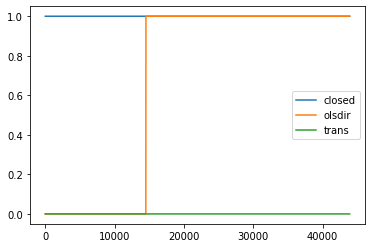

In [60]:
behavDat[['closed','olsdir','trans']][0:len(behavDat)-2].plot()